# Imports

In [12]:
from melanoma_classifier.pipeline import *
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *

In [13]:
wandb.init(project='melanoma-classification')

W&B Run: https://app.wandb.ai/bwolfson97/melanoma-classification/runs/2hgr5ew6

In [14]:
path = Path('/home/jupyter/data/melanoma-kaggle/'); path.ls()

(#6) [Path('/home/jupyter/data/melanoma-kaggle/test'),Path('/home/jupyter/data/melanoma-kaggle/sample_submission.csv'),Path('/home/jupyter/data/melanoma-kaggle/.csv'),Path('/home/jupyter/data/melanoma-kaggle/test.csv'),Path('/home/jupyter/data/melanoma-kaggle/train'),Path('/home/jupyter/data/melanoma-kaggle/train.csv')]

In [15]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


# Build DataLoaders

In [16]:
data = build_DataBlock(path/'train')
data = data.new(item_tfms=Resize(512), batch_tfms=aug_transforms(min_scale=0.7))

In [17]:
dls = data.dataloaders(df_train, bs=32)
xb, yb = dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 507, 507]), torch.Size([32]))

# Build Learner

In [18]:
learn = cnn_learner(dls, resnet50, metrics=RocAucBinary(), cbs=WandbCallback(log_model=False))

In [19]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [20]:
# learn.model.cuda()
# activs = learn.model(xb)
# activs.shape, activs[:2], F.softmax(activs[:2], dim=1)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=9.12010818865383e-07)

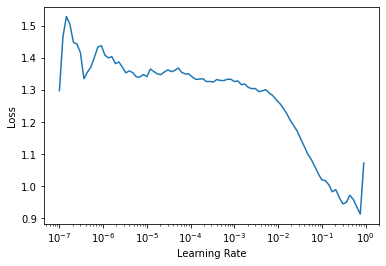

In [10]:
learn.lr_find()

In [ ]:
lr = 4e-2
learn.fit_one_cycle(3, lr_max=lr)

epoch,train_loss,valid_loss,roc_auc_score,time


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(lr/100,lr/10))

# Interpret Results

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses()

# Submit

In [ ]:
preds = get_preds(learn, path/'test.csv')

In [ ]:
create_submission_csv(path, preds)

In [ ]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "First submission trained on full dataset"